🚀 Entraînement sur : cuda
Épisode 10 | Step 190/100000 | Reward Moy (10 ep): 281.8
Épisode 20 | Step 474/100000 | Reward Moy (10 ep): 419.3
Épisode 30 | Step 683/100000 | Reward Moy (10 ep): 311.5
Épisode 40 | Step 930/100000 | Reward Moy (10 ep): 365.9
Épisode 50 | Step 1233/100000 | Reward Moy (10 ep): 449.9
Épisode 60 | Step 1433/100000 | Reward Moy (10 ep): 283.1
Épisode 70 | Step 1643/100000 | Reward Moy (10 ep): 302.3
Épisode 80 | Step 1843/100000 | Reward Moy (10 ep): 293.4
Épisode 90 | Step 2053/100000 | Reward Moy (10 ep): 308.9
Épisode 100 | Step 2294/100000 | Reward Moy (10 ep): 360.6
Épisode 110 | Step 2500/100000 | Reward Moy (10 ep): 294.9
Épisode 120 | Step 2685/100000 | Reward Moy (10 ep): 276.7
Épisode 130 | Step 2908/100000 | Reward Moy (10 ep): 331.7
Épisode 140 | Step 3188/100000 | Reward Moy (10 ep): 415.7
Épisode 150 | Step 3382/100000 | Reward Moy (10 ep): 291.5
Épisode 160 | Step 3571/100000 | Reward Moy (10 ep): 271.1
Épisode 170 | Step 3772/100000 | Reward Moy

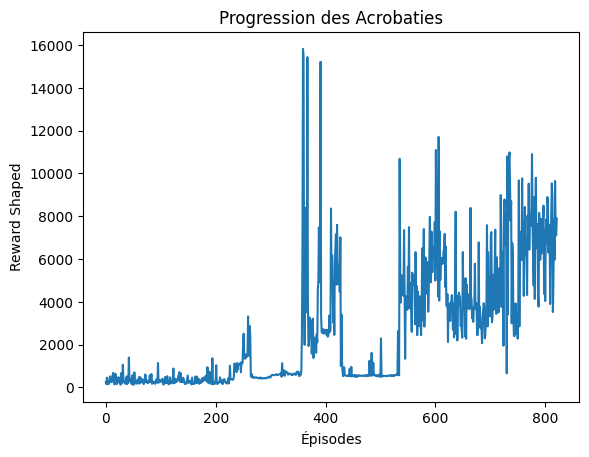

In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
import time

# -------------------------
# Hyperparamètres "Acrobaties"
# -------------------------
ENV_NAME = "Hopper-v5"
SEED = 42
MAX_STEPS = 100000      # Environ 20-30 min sur GPU
START_STEPS = 5000      # Exploration initiale
UPDATE_AFTER = 1000     
UPDATE_EVERY = 50       
BATCH_SIZE = 256
GAMMA = 0.98            # Priorité aux sauts immédiats
TAU = 0.005             
POLICY_LR = 3e-4        
Q_LR = 3e-4             
ALPHA_LR = 3e-4         
HIDDEN = 256            
REPLAY_SIZE = int(1e6)  

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Entraînement sur : {DEVICE}")

# -------------------------
# Utils : Replay Buffer
# -------------------------
Transition = namedtuple("Transition", ("s", "a", "r", "s2", "done"))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

# -------------------------
# Networks
# -------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, HIDDEN), nn.ReLU(),
            nn.Linear(HIDDEN, HIDDEN), nn.ReLU(),
            nn.Linear(HIDDEN, 1)
        )
    def forward(self, s, a):
        return self.net(torch.cat([s, a], dim=-1))

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, HIDDEN), nn.ReLU(),
            nn.Linear(HIDDEN, HIDDEN), nn.ReLU()
        )
        self.mu = nn.Linear(HIDDEN, action_dim)
        self.log_std = nn.Linear(HIDDEN, action_dim)

    def forward(self, s):
        x = self.net(s)
        mu = self.mu(x)
        log_std = torch.clamp(self.log_std(x), -20, 2)
        return mu, log_std.exp()

    def sample(self, s):
        mu, std = self.forward(s)
        dist = torch.distributions.Normal(mu, std)
        z = dist.rsample()
        action = torch.tanh(z)
        log_prob = (dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)).sum(dim=-1, keepdim=True)
        return action, log_prob, torch.tanh(mu)

# -------------------------
# Agent SAC
# -------------------------
class SACAgent:
    def __init__(self, env):
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.act_limit = float(env.action_space.high[0])

        self.policy = GaussianPolicy(self.state_dim, self.action_dim).to(DEVICE)
        self.q1 = QNetwork(self.state_dim, self.action_dim).to(DEVICE)
        self.q2 = QNetwork(self.state_dim, self.action_dim).to(DEVICE)
        self.q1_t = QNetwork(self.state_dim, self.action_dim).to(DEVICE)
        self.q2_t = QNetwork(self.state_dim, self.action_dim).to(DEVICE)
        self.q1_t.load_state_dict(self.q1.state_dict())
        self.q2_t.load_state_dict(self.q2.state_dict())

        self.p_opt = optim.Adam(self.policy.parameters(), lr=POLICY_LR)
        self.q_opt = optim.Adam(list(self.q1.parameters()) + list(self.q2.parameters()), lr=Q_LR)
        
        self.target_entropy = -float(self.action_dim)
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=DEVICE)
        self.a_opt = optim.Adam([self.log_alpha], lr=ALPHA_LR)

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            a, _, mu = self.policy.sample(state)
        return (mu if evaluate else a).cpu().numpy().squeeze(0) * self.act_limit

    def update(self, replay):
        batch = replay.sample(BATCH_SIZE)
        s = torch.FloatTensor(np.array(batch.s)).to(DEVICE)
        a = torch.FloatTensor(np.array(batch.a)).to(DEVICE) / self.act_limit
        r = torch.FloatTensor(np.array(batch.r)).to(DEVICE).unsqueeze(-1)
        s2 = torch.FloatTensor(np.array(batch.s2)).to(DEVICE)
        d = torch.FloatTensor(np.array(batch.done)).to(DEVICE).unsqueeze(-1)

        alpha = self.log_alpha.exp()
        with torch.no_grad():
            a2, lp2, _ = self.policy.sample(s2)
            q_t = torch.min(self.q1_t(s2, a2), self.q2_t(s2, a2)) - alpha * lp2
            target = r + GAMMA * (1 - d) * q_t

        # Critic Update
        self.q_opt.zero_grad()
        (nn.MSELoss()(self.q1(s, a), target) + nn.MSELoss()(self.q2(s, a), target)).backward()
        self.q_opt.step()

        # Actor Update
        pi, lp, _ = self.policy.sample(s)
        q_pi = torch.min(self.q1(s, pi), self.q2(s, pi))
        self.p_opt.zero_grad()
        (alpha * lp - q_pi).mean().backward()
        self.p_opt.step()

        # Alpha Update
        self.a_opt.zero_grad()
        (-(self.log_alpha * (lp + self.target_entropy).detach()).mean()).backward()
        self.a_opt.step()

        # Soft Update
        for p, pt in zip(self.q1.parameters(), self.q1_t.parameters()): pt.data.copy_(TAU * p.data + (1-TAU) * pt.data)
        for p, pt in zip(self.q2.parameters(), self.q2_t.parameters()): pt.data.copy_(TAU * p.data + (1-TAU) * pt.data)

# -------------------------
# Boucle d'entraînement
# -------------------------
env = gym.make(ENV_NAME)
agent = SACAgent(env)
replay = ReplayBuffer(REPLAY_SIZE)
history = []
total_steps, ep = 0, 0

while total_steps < MAX_STEPS:
    state, _ = env.reset()
    ep_reward, done = 0, False
    
    while not done:
        if total_steps < START_STEPS:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        next_state, reward, term, trunc, _ = env.step(action)
        
        # Reward Shaping: Hauteur (index 0) et Rotation (index 5)
        # On multiplie par 10 pour que l'agent comprenne vite l'intérêt de sauter haut
        r_shaped = reward + (next_state[0] * 10.0) + (abs(next_state[5]) * 5.0)
        
        replay.push(state, action, r_shaped, next_state, float(term or trunc))
        state, ep_reward = next_state, ep_reward + r_shaped
        total_steps += 1
        done = term or trunc

        if total_steps >= UPDATE_AFTER and total_steps % UPDATE_EVERY == 0:
            for _ in range(UPDATE_EVERY): agent.update(replay)

    history.append(ep_reward)
    ep += 1
    if ep % 10 == 0:
        avg = np.mean(history[-10:])
        print(f"Épisode {ep} | Step {total_steps}/{MAX_STEPS} | Reward Moy (10 ep): {avg:.1f}")

# -------------------------
# Test Final avec Rendu
# -------------------------
env_test = gym.make(ENV_NAME, render_mode="human")
agent.policy.eval()

for i in range(5):
    obs, _ = env_test.reset()
    done = False
    print(f"🎬 Démonstration {i+1}...")
    while not done:
        action = agent.select_action(obs, evaluate=True)
        obs, _, term, trunc, _ = env_test.step(action)
        done = term or trunc
        time.sleep(0.01)
env_test.close()

# Plot
plt.plot(history)
plt.title("Progression des Acrobaties")
plt.xlabel("Épisodes"); plt.ylabel("Reward Shaped")
plt.show()

In [4]:
# -------------------------
# 💾 Sauvegarde du modèle acrobatique
# -------------------------
model_path = "hopper_salto_sac.pth"
torch.save(agent.policy.state_dict(), model_path)
print(f"✅ Modèle sauvegardé sous : {model_path}")

# -------------------------
# 🎬 Visualisation du Salto
# -------------------------
import gymnasium as gym
import torch
import numpy as np
import time

# On recrée l'environnement pour le rendu visuel
env_test = gym.make(ENV_NAME, render_mode="human")

# Note : On n'utilise pas forcément NormalizeObservation ici SI 
# tu ne l'as pas mis dans ton code d'entraînement des acrobaties.
# env_test = gym.wrappers.NormalizeObservation(env_test)

# Chargement (optionnel si tu l'as déjà en mémoire)
# agent.policy.load_state_dict(torch.load(model_path))
agent.policy.eval() 

print("\n🚀 Lancement du test : Observe bien les rotations !")

for ep in range(5): # On lance 5 épisodes pour bien voir
    obs, _ = env_test.reset()
    done = False
    total_reward = 0
    steps = 0

    print(f"🎬 Épisode {ep + 1}")

    while not done:
        # 1. Préparation de l'observation
        obs_t = torch.tensor(obs, dtype=torch.float32).to(DEVICE).unsqueeze(0)

        # 2. Sélection de l'action déterministe (Meilleure rotation possible)
        with torch.no_grad():
            _, _, mu = agent.policy.sample(obs_t)
            action_numpy = mu.cpu().numpy().squeeze(0) * agent.act_limit

        # 3. Exécution
        obs, reward, terminated, truncated, _ = env_test.step(action_numpy)
        done = terminated or truncated
        total_reward += reward
        steps += 1

        # Petite pause pour fluidifier le rendu à l'oeil nu
        time.sleep(0.01)

    print(f"✨ Fin épisode | Score (Shaped) : {total_reward:.2f} | Steps : {steps}")
    time.sleep(1)

env_test.close()
print("\n🏁 Test de performance acrobatique terminé.")

✅ Modèle sauvegardé sous : hopper_salto_sac.pth

🚀 Lancement du test : Observe bien les rotations !
🎬 Épisode 1
✨ Fin épisode | Score (Shaped) : 328.38 | Steps : 149
🎬 Épisode 2
✨ Fin épisode | Score (Shaped) : 337.45 | Steps : 157
🎬 Épisode 3
✨ Fin épisode | Score (Shaped) : 792.75 | Steps : 264
🎬 Épisode 4
✨ Fin épisode | Score (Shaped) : 371.41 | Steps : 144
🎬 Épisode 5
✨ Fin épisode | Score (Shaped) : 336.11 | Steps : 139

🏁 Test de performance acrobatique terminé.
